In [26]:
import json
from pathlib import Path
import pandas as pd
from loguru import logger

# Path to JSON file
json_path = Path("/Users/ywxiu/jasp-multimodal-rag/data/processed/Statistical-Analysis-in-JASP-A-guide-for-students-2025_section_enriched.json")

# Load
with open(json_path, "r") as f:
    data = json.load(f)

# --- Detect structure ---
if isinstance(data, dict) and "sections" in data:
    sections = data["sections"]
    logger.info(f"Detected multi-section JSON with {len(sections)} sections (inside 'sections').")

elif isinstance(data, dict):
    sections = [data]
    logger.warning("Detected single-section JSON (wrapped in list).")

elif isinstance(data, list):
    sections = data
    logger.info(f"Detected list-based JSON with {len(sections)} sections.")

else:
    raise ValueError(f"Unsupported JSON structure: {type(data)}")

# --- Convert to DataFrame ---
rows = []
for s in sections:
    meta = s.get("metadata", {}) if isinstance(s, dict) else {}
    rows.append({
        "section_id": meta.get("section_id", ""),
        "title": meta.get("section_title", ""),
        "text_length": len(s.get("text", "")) if isinstance(s, dict) else 0,
        "token_length": meta.get("token_length", None),
        "page_start": meta.get("page_start", None),
        "pdf_name": meta.get("pdf_name", "")
    })

df = pd.DataFrame(rows)

logger.info(f"✅ Created dataframe with {len(df)} rows")
df.head()


2025-11-08 00:12:08.784 | INFO     | __main__:<module>:24 - Detected list-based JSON with 270 sections.
2025-11-08 00:12:08.813 | INFO     | __main__:<module>:44 - ✅ Created dataframe with 270 rows


,section_id,title,text_length,token_length,page_start,pdf_name
0,USING_THE_JASP_ENVIRONMENT_PAGE_6,USING THE JASP ENVIRONMENT,3596,603,6,Statistical-Analysis-in-JASP-A-guide-for-stude...
1,USING_THE_JASP_ENVIRONMENT_PAGE_6,USING THE JASP ENVIRONMENT,2199,361,6,Statistical-Analysis-in-JASP-A-guide-for-stude...
2,DATA_HANDLING_IN_JASP_PAGE_12,DATA HANDLING IN JASP,1929,316,12,Statistical-Analysis-in-JASP-A-guide-for-stude...
3,DATA_HANDLING_IN_JASP_PAGE_12,DATA HANDLING IN JASP,767,118,12,Statistical-Analysis-in-JASP-A-guide-for-stude...
4,DATA_EDITING_IN_JASP_PAGE_15,DATA EDITING IN JASP,441,74,15,Statistical-Analysis-in-JASP-A-guide-for-stude...


In [27]:
summary = df[["text_length", "token_length"]].describe().T
summary["median"] = df[["text_length", "token_length"]].median()
summary


,count,mean,std,min,25%,50%,75%,max,median
text_length,270.0,1373.525926,1162.956780,137.0,610.00,1056.5,1809.5,8326.0,1056.5
token_length,270.0,217.374074,188.534607,19.0,94.25,164.0,279.5,1276.0,164.0


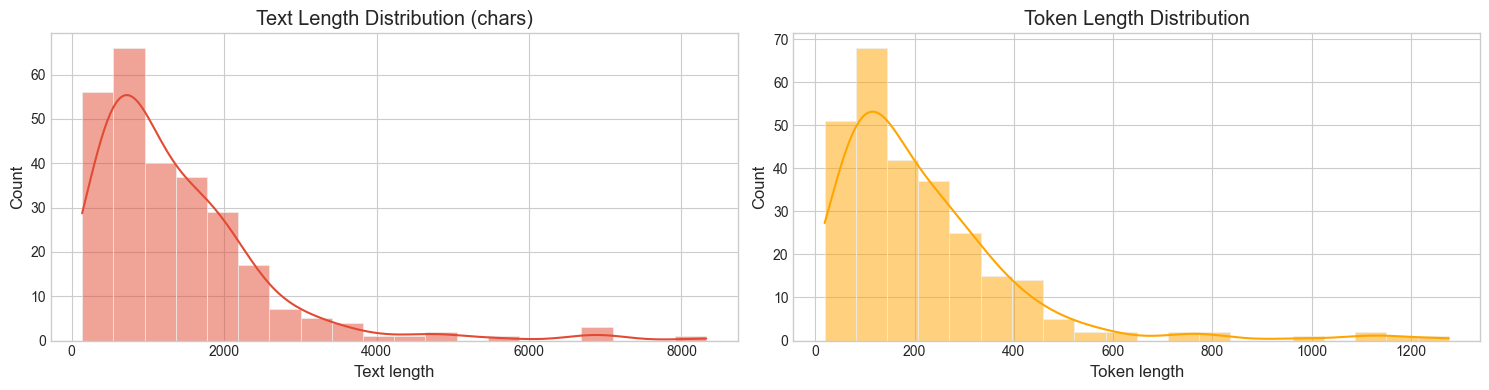

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: extract image counts if available
if "metadata" in df.columns or "image_paths" not in df.columns:
    # Try reconstructing from raw JSON for safety
    for i, s in enumerate(sections):
        meta = s.get("metadata", {}) if isinstance(s, dict) else {}
        df.loc[i, "image_count"] = len(meta.get("image_paths", []))
else:
    df["image_count"] = df["image_paths"].apply(lambda x: len(x) if isinstance(x, list) else 0)

# --- Plot setup ---
plt.style.use("seaborn-v0_8-whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

# --- 1️⃣ Text length distribution ---
sns.histplot(df["text_length"], bins=20, ax=axes[0], kde=True)
axes[0].set_title("Text Length Distribution (chars)")
axes[0].set_xlabel("Text length")
axes[0].set_ylabel("Count")

# --- 2️⃣ Token length distribution ---
sns.histplot(df["token_length"].dropna(), bins=20, ax=axes[1], color="orange", kde=True)
axes[1].set_title("Token Length Distribution")
axes[1].set_xlabel("Token length")
axes[1].set_ylabel("Count")


plt.tight_layout()
plt.show()





In [29]:
import json
from pathlib import Path
from loguru import logger
from transformers import AutoTokenizer
from llama_index.core.node_parser import SentenceSplitter
import pandas as pd

In [30]:

# -------------------------------------------------------------------------
# CONFIG
# -------------------------------------------------------------------------
INPUT_JSON = Path("../data/processed/Statistical-Analysis-in-JASP-A-guide-for-students-2025_section_enriched.json")
OUTPUT_DIR = Path("../data/processed/chunks")
EMBED_MODEL = "BAAI/bge-large-en-v1.5"
MAX_TOKENS = 500
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# ------

In [31]:
# LOAD DATA
# -------------------------------------------------------------------------
with open(INPUT_JSON, "r") as f:
    data = json.load(f)

if isinstance(data, dict) and "sections" in data:
    sections = data["sections"]
elif isinstance(data, list):
    sections = data
else:
    sections = [data]

logger.info(f"Loaded {len(sections)} sections from {INPUT_JSON.name}")

2025-11-08 00:12:43.571 | INFO     | __main__:<module>:13 - Loaded 270 sections from Statistical-Analysis-in-JASP-A-guide-for-students-2025_section_enriched.json


In [32]:



# -------------------------------------------------------------------------
# SPLIT LONG SECTIONS
# -------------------------------------------------------------------------
tokenizer = AutoTokenizer.from_pretrained(EMBED_MODEL)
splitter = SentenceSplitter(chunk_size=MAX_TOKENS, chunk_overlap=50)

all_chunks = []

for section in sections:
    text = section.get("text", "")
    meta = section.get("metadata", {})
    token_len = len(tokenizer.tokenize(text))

    if token_len <= MAX_TOKENS:
        section["metadata"]["token_length"] = token_len
        all_chunks.append(section)
        continue

    logger.info(f"Splitting section {meta.get('section_id', 'unknown')} ({token_len} tokens)")
    chunks = splitter.split_text(text)

    for i, chunk in enumerate(chunks):
        new_section = section.copy()
        new_meta = meta.copy()
        new_meta["sub_section_id"] = f"{meta.get('section_id', 'sec')}_part{i+1}"
        new_meta["token_length"] = len(tokenizer.tokenize(chunk))
        new_section["text"] = chunk
        new_section["metadata"] = new_meta
        all_chunks.append(new_section)

# -------------------------------------------------------------------------
# SAVE OUTPUT
# -------------------------------------------------------------------------
output_path = OUTPUT_DIR / f"{INPUT_JSON.stem}_chunks.json"
with open(output_path, "w") as f:
    json.dump({"sections": all_chunks}, f, indent=2)

logger.success(f"💾 Saved {len(all_chunks)} chunks → {output_path}")



Token indices sequence length is longer than the specified maximum sequence length for this model (825 > 512). Running this sequence through the model will result in indexing errors
2025-11-08 00:12:45.800 | INFO     | __main__:<module>:19 - Splitting section USING_THE_JASP_ENVIRONMENT_PAGE_6 (825 tokens)
2025-11-08 00:12:45.827 | INFO     | __main__:<module>:19 - Splitting section DATA_EDITING_IN_JASP_PAGE_15 (527 tokens)
2025-11-08 00:12:45.837 | INFO     | __main__:<module>:19 - Splitting section CENTRAL_TENDENCY_PAGE_20 (1267 tokens)
2025-11-08 00:12:45.845 | INFO     | __main__:<module>:19 - Splitting section SPLITTING_DATA_FILES_PAGE_25 (776 tokens)
2025-11-08 00:12:45.850 | INFO     | __main__:<module>:19 - Splitting section DESCRIPTIVE_DATA_VISUALISATION_PAGE_25 (560 tokens)
2025-11-08 00:12:45.860 | INFO     | __main__:<module>:19 - Splitting section WE_MAKE_MANY_ASSUMPTIONS_ABOUT_OUR_DATA_PAGE_36 (616 tokens)
2025-11-08 00:12:45.867 | INFO     | __main__:<module>:19 - Splitti

In [33]:
# -------------------------------------------------------------------------
# SUMMARY
# -------------------------------------------------------------------------
df = pd.DataFrame([
    {
        "section_id": s["metadata"].get("sub_section_id", s["metadata"].get("section_id")),
        "token_length": s["metadata"].get("token_length", 0)
    }
    for s in all_chunks
])

summary = df["token_length"].describe()
logger.info(f"\n📊 Token length summary:\n{summary}")

# -------------------------------------------------------------------------
# SHOW SAMPLE CHUNKS
# -------------------------------------------------------------------------
logger.info("\n🔍 Example chunks:")
for s in all_chunks[:3]:
    meta = s["metadata"]
    print("\n---")
    print(f"🆔 {meta.get('sub_section_id', meta.get('section_id'))}")
    print(f"📏 Tokens: {meta.get('token_length')}")
    print(f"📄 Preview: {s['text'][:600]}...")


2025-11-08 00:12:50.573 | INFO     | __main__:<module>:13 - 
📊 Token length summary:
count    313.000000
mean     259.476038
std      139.787271
min       24.000000
25%      139.000000
50%      230.000000
75%      383.000000
max      515.000000
Name: token_length, dtype: float64
2025-11-08 00:12:50.575 | INFO     | __main__:<module>:18 - 
🔍 Example chunks:



---
🆔 USING_THE_JASP_ENVIRONMENT_PAGE_6_part1
📏 Tokens: 511
📄 Preview: Open JASP.
The main menu can be accessed by clicking on the top-left icon.
Open:
JASP has its own . jasp format but can open a variety of
different dataset formats, such as:
.xls/xlsx (Excel files)
.csv (comma-separated values) can be saved in Excel
.txt (plain text) can also be saved in Excel
.tsv (tab-separated values) can also be saved in Excel
.sav (IBM SPSS data file)
.ods (Open Document spreadsheet)
.dta (Stata data file)
.por (SPSS ASCII file)
.Sas7bdat /cat (SAS data files)
.xpt (SAS transport file)
You can open recent files, browse your computer files, access the Open Scien ce Framewo...

---
🆔 USING_THE_JASP_ENVIRONMENT_PAGE_6_part2
📏 Tokens: 342
📄 Preview: The preferred language currently supports 13 languages: English, Spanish, German, Dutch, French,
Indonesian, Japanese, Portuguese, Chinese and Galician.
In this section, there is also the ability to change the system size  (zoom) for accessibility and 

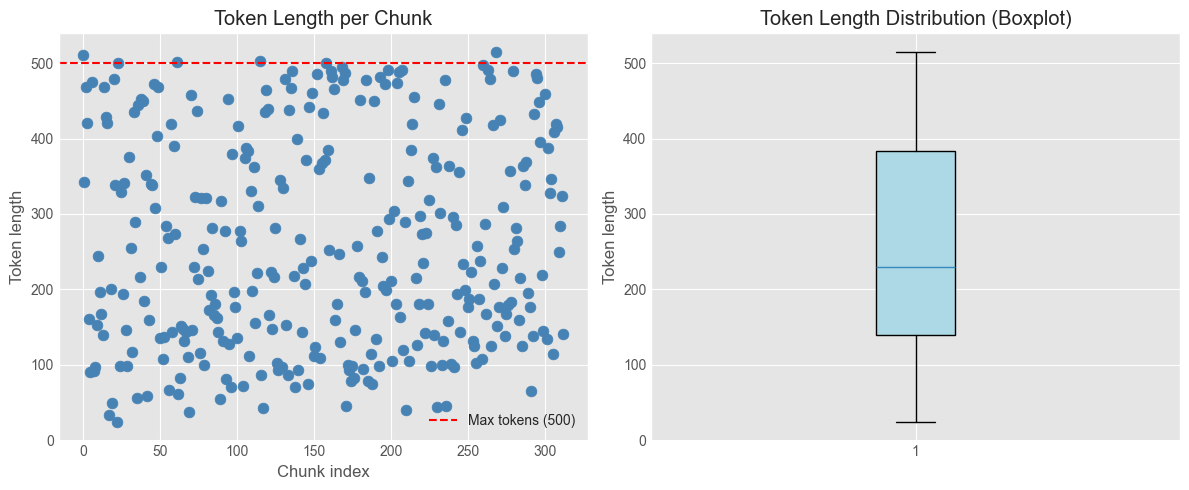

In [34]:
import matplotlib.pyplot as plt

plt.style.use("ggplot")
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 1️⃣ Scatter plot — token length per chunk index
axes[0].scatter(range(len(df)), df["token_length"], color="steelblue", s=60)
axes[0].axhline(y=MAX_TOKENS, color="red", linestyle="--", label=f"Max tokens ({MAX_TOKENS})")
axes[0].set_title("Token Length per Chunk")
axes[0].set_xlabel("Chunk index")
axes[0].set_ylabel("Token length")
axes[0].legend()

# 2️⃣ Boxplot — distribution overview
axes[1].boxplot(df["token_length"], vert=True, patch_artist=True, boxprops=dict(facecolor="lightblue"))
axes[1].set_title("Token Length Distribution (Boxplot)")
axes[1].set_ylabel("Token length")

plt.tight_layout()
plt.show()


In [35]:
# -------------------------------------------------------------------------
# FILTER OUT SECTIONS WITH EXTREME TOKEN LENGTHS
# -------------------------------------------------------------------------
too_short = df[df["token_length"] < 20]
too_long = df[df["token_length"] > 500]

logger.warning(f"⚠️ Found {len(too_short)} sections with token_length < 20")
logger.warning(f"⚠️ Found {len(too_long)} sections with token_length > 500")

# (Optional) Display examples
if not too_short.empty:
    logger.info("\n📉 Example of too-short sections:")
    print(too_short)

if not too_long.empty:
    logger.info("\n📈 Example of too-long sections:")
    print(too_long.head(5))


2025-11-08 00:13:06.010 | WARNING  | __main__:<module>:7 - ⚠️ Found 0 sections with token_length < 20
2025-11-08 00:13:06.012 | WARNING  | __main__:<module>:8 - ⚠️ Found 4 sections with token_length > 500
2025-11-08 00:13:06.013 | INFO     | __main__:<module>:16 - 
📈 Example of too-long sections:


                                  section_id  token_length
0    USING_THE_JASP_ENVIRONMENT_PAGE_6_part1           511
61   RUNNING_THE_BINOMIAL_TEST_PAGE_52_part1           501
115      REPORTING_THE_RESULTS_PAGE_76_part1           503
268        MIXED_FACTOR_ANOVA_PAGE_141_part1           515
